## Assignment 2 -- Yimeng Lu -- yimeng.lu@kaust.edu.sa -- Julia 0.6.0
## Problem 1
### Problem 1.a
- Compute smoothness
$M = diag(1/\alpha_i)\cdot(B^TB)+2\lambda I$
- Compute for $\omega_j$'s and store them in a vector
- Construct v

In [3]:
function myDiagonal_inverse(v)
    n = size(v, 1)
    M = eye(n)
    for i = 1:n
        M[i, i] = 1/v[i]
    end
    return M
end

myDiagonal_inverse (generic function with 1 method)

In [4]:
function myDiagonal(v)
    n = size(v, 1)
    M = eye(n)
    for i = 1:n
        M[i, i] = v[i]
    end
    return M
end

myDiagonal (generic function with 1 method)

In [5]:
# Compute ESO parameters for tau-nice sampling
function ComputeESO(B, alpha, gamma, tau)
    # B is n*d
    d = size(alpha, 1)
    n = size(B, 1)
    
    # smoothness
    # M = myDiagonal_inverse(alpha).*(B*B') + 2*gamma * eye(d)
    
    # A is n*d
    A = B * myDiagonal_inverse(alpha.^(1/2))
    omega = zeros(n, 1)
    for j = 1:d
        omega[j] = countnz(A[:, j])
    end
    
    v = zeros(n, 1)
    for i = 1:n
        for j = 1:d
            v[i] = v[i] + (1 + (omega[j]-1)*(tau-1)/max(n-1, 1) ) * A[i, j]^2
        end
    end
    v = v .+ 2*gamma*ones(n,1)
    return v, A
end

ComputeESO (generic function with 1 method)

### Problem 1.b
As in Thm.99, for all the samplings $\vert \hat{S} \vert \le \tau$, $$v_i=\sum_{j=1}^m \min\{\omega_j, \tau\}\mathbf{A}_{ji}^2$$
And also according to (148) in Thm.101, $\lambda(C_j\cap \hat{S}) \le \min\{\omega_j, \tau \}$, thus we can conclude that the v is tight. 

### Problem 1.c
Examine using Theorem 89. The problem becomes constructing P, p, M and evaluating the inequality in Thm. 89. 

In [6]:
# inputs
d = 10
n = 1000
gamma = 1/d
B = randn(n, d)
alpha = zeros(d, 1)
for j = 1:d
    alpha[j] = n/j
end

In [7]:
function construct_P(n, tau)
    P = zeros(n,n)
    p = zeros(n, 1)
    for i = 1:n
        for j = 1:n
            if i == j
                P[i,j] = tau/n
                p[i] = tau/n
            else
                P[i,j] = tau*(tau-1)/(n*(n-1))
            end
        end
    end
    return p,P
end

construct_P (generic function with 1 method)

In [8]:
function test_ESO(P,M,p,v)
    n = size(P,1)
    result = 1
    D = eigvals((P.*M) - myDiagonal(p.*v))
    if minimum(D) > 0
        result = 0
    end
    return result
end

test_ESO (generic function with 1 method)

In [10]:
p,P= construct_P(n,1)
v1, A = ComputeESO(B, alpha, gamma, 1)
M = (A*A') + 2*gamma * eye(n)
test_ESO(P,M,p,v1)

1

In [156]:
p,P= construct_P(n,200)
v200, A = ComputeESO(B, alpha, gamma, 200)
test_ESO(P,M,p,v200)

1

## Problem 2
### Problem 2.1

In [9]:
function compute_omega(tau)
    # Value computed here should multiply 1/lambda
    p,~ = construct_P(n, tau)
    v,~ = ComputeESO(B, alpha, gamma, tau)
    omega = maximum(v./p)
    return omega
end

compute_omega (generic function with 1 method)

In [75]:
using PyPlot
function PlotSpeedup(_max)
    ax = axes()
    omega = zeros(_max, 1)
    ys = zeros(_max, 1)
    numOfPlots = _max
    for i = 1:numOfPlots
        omega[i] = compute_omega(i)
        y = omega[1]/omega[i]  
        ys[i] = y
    end
    plot(collect(1:_max), ys, linewidth=3.0)
    legend(loc="upper right")
    ylabel("Speedup(tau)", fontsize=20)
    xlabel("tau")
    # println(omega./omega[1])
end

PlotSpeedup (generic function with 1 method)

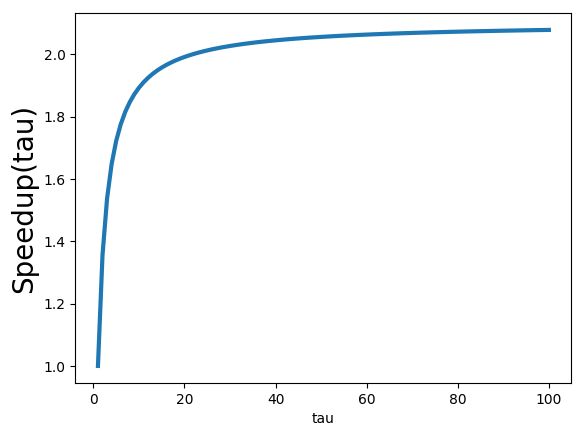

PyObject <matplotlib.text.Text object at 0x7fa0e0a7dd10>

In [78]:
PlotSpeedup(100)

### Problem 2.2
Test the function using different problems from (\*). 
2.1 is using a random B which is already dense, so we will test: 
- sparse B
- half-sparse B

#### Very sparse B ($\omega_j =1~\forall i$), complexity of $\tau$-nice is much better when $\tau$ is big. 

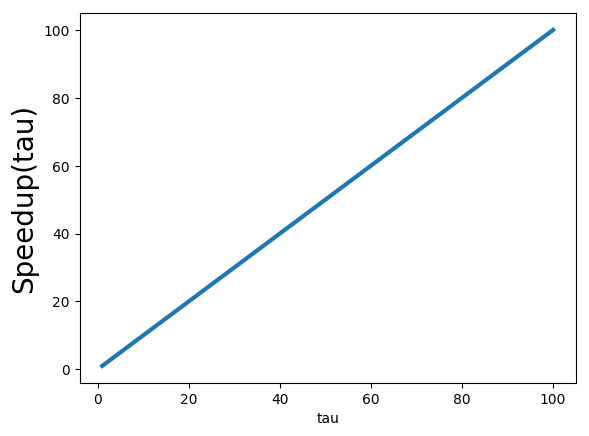

PyObject <matplotlib.text.Text object at 0x7fa0e0d44550>

In [79]:
B = sprandn(n, d, 1/n)
PlotSpeedup(100)

#### Not very sparse B. Still very efficient, but slower than previous case. 

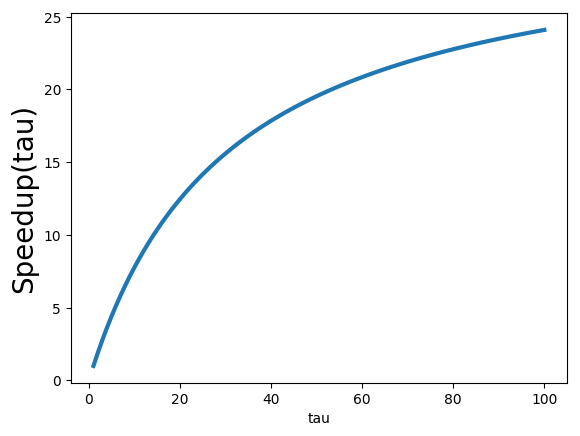

PyObject <matplotlib.text.Text object at 0x7fa0e0e59bd0>

In [80]:
B = sprandn(n, d, (1/n)*100)
PlotSpeedup(100)

### Problem 2.3
Fully sparse B, i.e., $\omega_j =1~\forall i$, because in this case, $\Omega_{\tau -nice}=\frac{1}{\tau}\Omega_{uniform}$. We can see this from the first plot on Problem 2.2, it the same as if we plot $\tau$

## Problem 3
### Problem 3.1


In [28]:
using PyPlot
function PlotResults(x_values, y_values, labels)
    ax = axes()
    numOfPlots = length(labels)
    for i = 1:numOfPlots
        plt[:plot](x_values, y_values[:,i], "-", linewidth=3.0, label=labels[i])
    end
    legend(loc="upper right")
    ylabel("error", fontsize=20)
    xlabel("iterations")
    ax[:set_yscale]("log")
    plt[:show]
    
end

PlotResults (generic function with 1 method)

In [11]:
function f(x, B, gamma, alpha)
    f = 0
    n = size(B, 1)
    d = size(B, 2)
    for j = 1:d
        f = f + phi_j((B[:, j]'*x)[1], alpha, j)
        #println(j)
    end
    f = f + gamma*( (x'*x)[1] )
    return f
end

f (generic function with 1 method)

In [12]:
function phi_j(s, alpha, j)
    result = 0
    if s < -1
        result = (s+1)^2/(2*alpha[j])
    elseif s > 1
        result = (s-1)^2/(2*alpha[j])
    end
    return result
end

phi_j (generic function with 1 method)

In [33]:
function ∇_f(B, x, gamma, alpha)
    delta_f = 2*gamma*x
    for i = 1:d
        bx = (B[:, i]'*x)[1]
        if  bx < -1
            phi = (bx+1)/alpha[i]
        elseif bx > 1
            phi = (bx-1)/alpha[i]
        else
            phi = 0
        end
        delta_f = delta_f .+ phi*2 *B[:, i]
    end
    return delta_f
end

∇_f (generic function with 1 method)

In [14]:
# Implementation of reservoir sampling: O(n) time, O(k) space complexity
function samplingK(k, n) 
    reservoir = collect(1:k)
    for i=(k+1):n
        pos = rand(1:i)
        if pos <= k
            reservoir[pos] = i
        end
    end
    return reservoir
end

samplingK (generic function with 1 method)

In [37]:
function NSyncMinibatch(B, alpha, gamma, tau, x0, k)# (A, b, lambda, T)
    
    n, d = size(B)
    
    # sampling
    p,P= construct_P(n,tau)
    v, A = ComputeESO(B, alpha, gamma, tau)
    
    
    
    x = x0    # staring point
    g = f(x0, B, gamma, alpha) 
    
    # plot preparation
    skip = 100
    numToPlot = floor(Int, k/skip) + 1
    xs = zeros(n,numToPlot)
    fv = zeros(numToPlot)
    
    for kk = 1:k
        tau_samples = samplingK(tau, n) 
        ∇ = ∇_f(B, x, gamma, alpha)
        #println( ∇)
        for i = tau_samples                                # choose a random index 
            h = (1/v[i]) * ∇[i]                # compute the update
            #println('h',h)
            x[i] = x[i] - h[1]                              # perform the update 
        end
        g = f(x, B, gamma, alpha)                          # update the residual
        if kk%skip == 0
            xs[:, round(Int,kk/skip)+1] = x;
            fv[round(Int,kk/skip)+1] = g; # functional value at x
        end
        
    end
    
    # Plot the errors
    y_values = zeros(numToPlot,2)
    y_values[:,1] = fv[:]; # the difference between f(x^k) and the optimal f(x^*)
    y_values[:,2] = [norm(xs[:,i]) for i=1:numToPlot] # the difference between iterates and x^*
    
    PlotResults(skip*(0:numToPlot-1), y_values, ["f(xk)", "||xk||"])
    
    
end

NSyncMinibatch (generic function with 1 method)

In [39]:
x0 = ones(1000, 1)*10
k = 5000
tau = 10

10

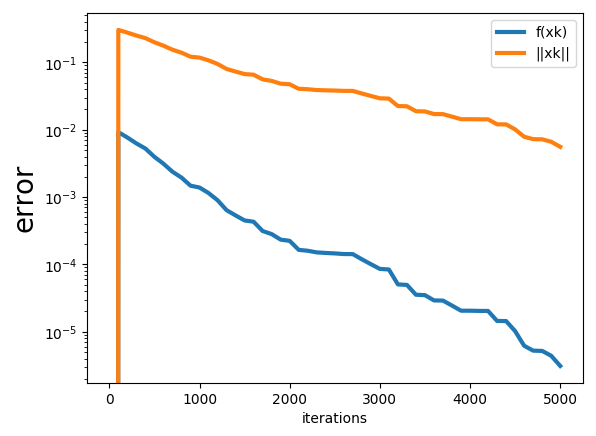

PyObject <function show at 0x7f561161db90>

In [41]:
NSyncMinibatch(B, alpha, gamma, tau, x0, k)

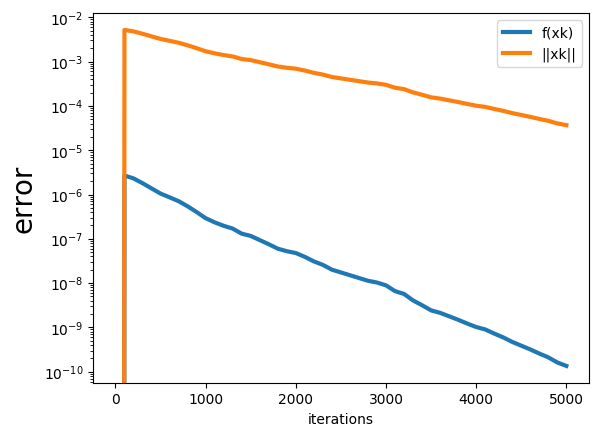

PyObject <function show at 0x7f561161db90>

In [42]:
tau = 100
NSyncMinibatch(B, alpha, gamma, tau, x0, k)

Higher $\tau$ gives faster convergence. 

### Problem 3.2
The optimal solution of (\*) is 0 as it's a non-negative function and using zero vector yields 0. 